In [136]:
# --- Required Libraries ---
import numpy as np                            # For numerical computations
import pandas as pd                          # For handling datasets
import random                                 # For generating random numbers

# --- For Visualizations (Data analysis) ---
import matplotlib.pyplot as plt               # For creating basic plots and graphs
import seaborn as sns                        # For enhanced visualizations (e.g., heatmaps, pairplots)
from matplotlib.lines import Line2D           # For advanced plotting (e.g., legends with custom lines)

# --- For Statistical Description (Descriptive statistics and statistical analysis) ---
import scipy.stats as stats                  # For statistical functions like skew, kurtosis
from sklearn.preprocessing import MinMaxScaler # For scaling and normalization

# --- For Preprocessing (Data cleaning, encoding, balancing, etc.) ---
from sklearn.model_selection import train_test_split # For splitting datasets into train, validation, and test sets
from sklearn.preprocessing import LabelEncoder           # For encoding categorical variables into numeric labels
from sklearn.impute import SimpleImputer                # For handling missing values (mean/median imputation)
from sklearn.utils import resample                      # For up/down sampling the dataset

# --- For LSTM (Deep Learning) (Model building and training) ---
import tensorflow as tf                             # TensorFlow for building and training deep learning models
from tensorflow.keras.models import Sequential      # For creating sequential models
from tensorflow.keras.models import Model           # For using the functional API to build models
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional # For LSTM layers and others
from tensorflow.keras.optimizers import Adam        # Adam optimizer for model training
from tensorflow.keras.callbacks import EarlyStopping # Early stopping to prevent overfitting

# --- For Metrics (For evaluating model performance) ---
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # For regression evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix  # For classification metrics


In [137]:
# Load the dataset
data = pd.read_csv('/Users/administrator/Desktop/All desktop-data/Dr.Ali/dataset/Dataset and Code/Dataset/iot_smart_city_dataset.csv')

# Display descriptive statistics
print("Descriptive Statistics for the Dataset:\n", data.describe())


Descriptive Statistics for the Dataset:
        uptime_hours  battery_capacity_mAh  energy_consumption_mAh  \
count  60000.000000          60000.000000            60000.000000   
mean      11.571667           3004.149850              186.828537   
std        6.920831           1153.084715              111.739189   
min        0.000000           1000.000000                0.000000   
25%        6.000000           2007.000000               96.872063   
50%       12.000000           3010.000000              193.744126   
75%       18.000000           3998.250000              290.616188   
max       23.000000           4999.000000              371.342907   

       temperature_C  humidity_percent  air_quality_index  motion_events  \
count   60000.000000      60000.000000       60000.000000   60000.000000   
mean       24.992034         82.505883         248.967000      49.442550   
std         5.768543          5.948904         144.015029      28.843315   
min        15.000169         70.0

In [138]:
# Check the columns in the dataset
print(data.columns)


Index(['timestamp', 'device_id', 'device_type', 'uptime_hours',
       'battery_capacity_mAh', 'energy_consumption_mAh', 'temperature_C',
       'humidity_percent', 'air_quality_index', 'motion_events',
       'light_intensity_lux', 'noise_level_dB', 'co2_emissions_ppm',
       'wind_speed_m_s', 'precipitation_mm_h', 'traffic_density_vehicles_h',
       'noise_pollution_level_dB', 'anomaly'],
      dtype='object')


In [139]:
# Rename columns for easier access
rename_dict = {
    'timestamp': 'TS', 'device_id': 'DID', 'device_type': 'Type', 
    'uptime_hours': 'UPU', 'battery_capacity_mAh': 'BC', 
    'energy_consumption_mAh': 'EC', 'temperature_C': 'Temp', 
    'humidity_percent': 'Hum', 'air_quality_index': 'AQI', 
    'motion_events': 'ME', 'light_intensity_lux': 'Lux', 
    'noise_level_dB': 'NL', 'co2_emissions_ppm': 'CO2', 
    'wind_speed_m_s': 'WS', 'precipitation_mm_h': 'Precip', 
    'traffic_density_vehicles_h': 'TDV', 'noise_pollution_level_dB': 'NPL', 
    'anomaly': 'Anom'
}
data.rename(columns=rename_dict, inplace=True)

# Features (input variables) and targets (outputs)
features = ['UPU', 'BC', 'Temp', 'Hum', 'AQI', 'ME', 'Lux', 'NL', 'CO2', 'WS', 'Precip', 'TDV', 'NPL']
X = data[features]  # Input features
y_energy = data['EC']  # Energy consumption target (regression)
y_anomaly = data['Anom']  # Anomaly detection target (binary classification)

# Split the data into training and validation sets (80%/20%)
X_train, X_val, y_train_energy, y_val_energy, y_train_anomaly, y_val_anomaly = train_test_split(
    X, y_energy, y_anomaly, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}, Validation set shape: {X_val.shape}")


Training set shape: (48000, 13), Validation set shape: (12000, 13)


In [140]:
# --- Scaling the features ---
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Reshape the data for LSTM [samples, timesteps, features]
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))


In [141]:
# --- Build the LSTM Model for EC (Energy Consumption) ---
model = Sequential([
    LSTM(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.3),
    Dense(1, name='EC_output')  # Output layer for energy consumption (regression)
])

# --- Compile the model ---
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[r2_score])

# Print model summary to check layers
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 64)                19968     
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 EC_output (Dense)           (None, 1)                 65        
                                                                 
Total params: 20033 (78.25 KB)
Trainable params: 20033 (78.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [143]:
from tensorflow.keras import backend as K

# Define R² metric function
def r2_metric(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))  # Residual sum of squares
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))  # Total sum of squares
    return 1 - ss_res / (ss_tot + K.epsilon())  # R² formula


In [144]:
# --- Compile the model for Energy Consumption prediction ---
model.compile(
    optimizer='adam',
    loss='mean_squared_error',  # For regression
    metrics=[r2_metric]  # Use the custom R² metric
)


In [145]:
history = model.fit(
    X_train_reshaped, 
    y_train_energy,  # Energy Consumption output (EC)
    epochs=50, 
    batch_size=32, 
    validation_data=(X_val_reshaped, y_val_energy),
    verbose=1
)


Epoch 1/50
1500/1500 [==============================] - 4s 2ms/step - loss: 32355.9727 - r2_metric: -1.7213 - val_loss: 22410.1035 - val_r2_metric: -0.8997
Epoch 2/50
1500/1500 [==============================] - 3s 2ms/step - loss: 18236.1914 - r2_metric: -0.5203 - val_loss: 14650.6777 - val_r2_metric: -0.2320
Epoch 3/50
1500/1500 [==============================] - 3s 2ms/step - loss: 12949.8457 - r2_metric: -0.0743 - val_loss: 8478.8975 - val_r2_metric: 0.2875
Epoch 4/50
1500/1500 [==============================] - 3s 2ms/step - loss: 5342.6177 - r2_metric: 0.5575 - val_loss: 2818.8306 - val_r2_metric: 0.7648
Epoch 5/50
1500/1500 [==============================] - 3s 2ms/step - loss: 2220.8298 - r2_metric: 0.8167 - val_loss: 1125.6814 - val_r2_metric: 0.9066
Epoch 6/50
1500/1500 [==============================] - 3s 2ms/step - loss: 1184.7739 - r2_metric: 0.9019 - val_loss: 449.1791 - val_r2_metric: 0.9628
Epoch 7/50
1500/1500 [==============================] - 3s 2ms/step - loss: 811

In [146]:
# --- Evaluate the model on validation data ---
y_pred_energy = model.predict(X_val_reshaped)

# Compute the evaluation metrics
mae = mean_absolute_error(y_val_energy, y_pred_energy)
mse = mean_squared_error(y_val_energy, y_pred_energy)
rmse = np.sqrt(mse)

# For R², TensorFlow's internal R² is used in the training process
train_r2 = history.history['r2_metric'][-1]  # Get the final R² for training
val_r2 = history.history['val_r2_metric'][-1]  # Get the final R² for validation

# Print final metrics for energy consumption (EC)
print(f"Final EC Metrics:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"Training R²: {train_r2}")
print(f"Validation R²: {val_r2}")


375/375 [==============================] - 1s 954us/step
Final EC Metrics:
MAE: 1.3290572926712607
MSE: 4.0928896780524955
RMSE: 2.0230891423890585
Training R²: 0.9783332347869873
Validation R²: 0.9996631145477295


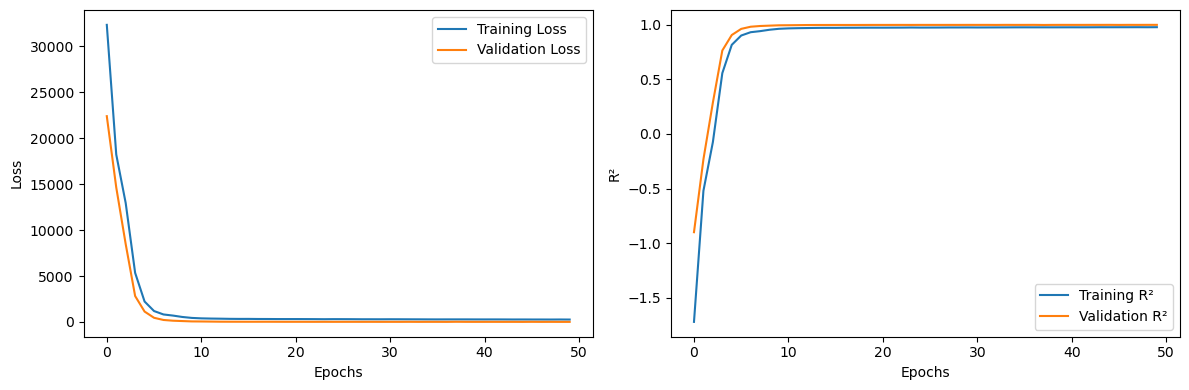

In [158]:
import matplotlib.pyplot as plt

# --- Create a figure with 1 row and 2 columns ---
plt.figure(figsize=(12, 4))

# --- First Plot: EC - Training and Validation Loss ---
plt.subplot(1, 2, 1)  # First subplot (1 row, 2 columns, first plot)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.title('EC - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# --- Second Plot: EC - R² Score Across Epochs ---
plt.subplot(1, 2, 2)  # Second subplot (1 row, 2 columns, second plot)
plt.plot(history.history['r2_metric'], label='Training R²')  # Training R²
plt.plot(history.history['val_r2_metric'], label='Validation R²')  # Validation R²
# plt.title('EC - R² Score Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.legend()

# --- Adjust layout for better spacing ---
plt.tight_layout()

# --- Show the plots ---
plt.show()


In [157]:
# Store the final evaluation results in history
history_dict = history.history

# Print the final training and validation loss and R² metrics
print(f"Training Loss: {history_dict['loss'][-1]}")
print(f"Validation Loss: {history_dict['val_loss'][-1]}")
print(f"Training R²: {history_dict['r2_metric'][-1]}")
print(f"Validation R²: {history_dict['val_r2_metric'][-1]}")


Training Loss: 256.5243225097656
Validation Loss: 4.092884540557861
Training R²: 0.9783332347869873
Validation R²: 0.9996631145477295
